In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy import interpolate

In [2]:
models = ['CDM','DCDM','Mixed']
ratios_cdm = {'CDM':1.,'DCDM':0.,'Mixed':0.5}
Gamma_dcdm = 6.

#z_pk = [200.0,100.0,75.0,50.0,10.0,5.0,0.0]
z_pk = [100.0,10.0,5.0,3.0,1.0,0.5,0.0]
k_out = [0.00001,0.0001, 0.001, 0.01,.1]
z_init = 2000.
cosmo = {}
for M in models:
    print M
    cosmo[M] = Class()
    cosmo[M].set({'output':'mPk dTk lTk', 
           'z_pk':str(z_pk).strip('[]'),
           'k_output_values':str(k_out).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'switch_radiation_source':1,
                  'switch_dr_source':1,
           'switch_gamma':1,
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':2,
           'l_max_g':100,
           'l_max_ur':100,
           'l_max_pol_g':100, 
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':60,
           'k_per_decade_for_bao':120,
           'gauge' : 'Newtonian',
           'P_k_max_1/Mpc' : 1.1,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-3,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.24*ratios_cdm[M]+1e-6,
           'Omega_dcdmdr':0.24*(1-ratios_cdm[M]),
           'Gamma_dcdm':Gamma_dcdm,
                  'background_verbose':3
#           'N_ur':0.0,
#           'YHe':0.25,
#           'Omega_b':0.05,
#           'Omega_cdm':0.95
            })
#for key, val in cosmo.pars.iteritems():
#    print key,' = ',val
    cosmo[M].compute()

CDM
DCDM
Mixed


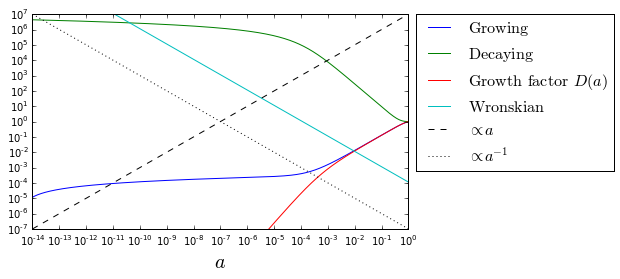

In [3]:
aminexp = -14
amin = 10**aminexp
ymin = 10**(aminexp/2.)
ymax = 10**(-aminexp/2.)

bg = cosmo['CDM'].get_background()

a = 1./(bg['z']+1)
H = bg['H [1/Mpc]']
grow = bg['grow']
grow_prime = bg['grow_prime']
#W= bg['Wronskian']
#decay= bg['decay']
decay= bg['bwdec']
decay_prime = bg['bwdec_prime']
D = bg['gr.fac. D']
f = bg['gr.fac. f']

W = grow*decay_prime-decay*grow_prime

grow_interp = interpolate.interp1d(a,grow)
decay_interp = interpolate.interp1d(a,decay)


#N=abs(grow[-1]/decay[-1])
plt.loglog(a,grow/grow[-1])
plt.loglog(a,decay/decay[-1])
plt.loglog(a,D/D[-1])
plt.loglog(a,abs(W)/grow[-1]/decay[-1])

plt.loglog(a,a*ymax,'k--')
plt.loglog(a,1./a*ymin,'k:')


lgd = plt.legend([r'$\mathrm{Growing}$',r'$\mathrm{Decaying}$',r'$\mathrm{Growth}\,\mathrm{factor}\, D(a)$',
                  r'$\mathrm{Wronskian}$',r'$\propto a$',r'$\propto a^{-1}$'],
           fontsize=16,ncol=1,loc='upper left',
           bbox_to_anchor=(1.0, 1.04))
#plt.ylim([1e-18,1e14])
#plt.ylim([1e-74,1e23])
plt.xlabel(r'$a$',fontsize=20)
plt.ylim([ymin,ymax])
plt.tight_layout()
plt.savefig('GrowingDecayingBackground.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

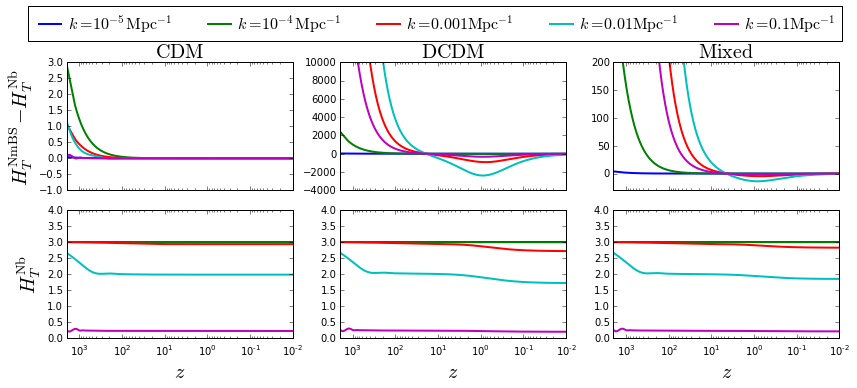

In [4]:
def dbl2str(k):
    if k<1e-3:
        exponent = int(np.log10(k))
        return '10^{'+str(exponent)+'}'
    else:
        return str(k)
yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
f, axes = plt.subplots(2,3,sharex=True,figsize=(12,5))
for j, M in enumerate(models):
    pt = cosmo[M].get_perturbations()
    pts = pt['scalar']

    for idx, k in enumerate(k_out):
        pt = pts[idx]
        S1 = grow_interp(pt['a'])
        S2 = decay_interp(pt['a'])
        HTNb = pt['H_T_nm']+k*pt['L']
        z = 1./pt['a']-1
        axes[0,j].semilogx(z,(pt['CHT_grow']-pt['CHT_grow'][-1])*S1+(pt['CHT_decay']-pt['CHT_decay'][-1]+0.0)*S2+.0*HTNb,lw=2)
        axes[1,j].semilogx(z,np.abs(HTNb),lw=2)
    axes[0,j].set_ylim(yls[M])
    axes[1,j].set_ylim([0,4])

axes[0,0].set_ylabel(r'$H_T^\mathrm{NmBS}-H_T^\mathrm{Nb}$',fontsize=20)
axes[1,0].set_ylabel(r'$H_T^\mathrm{Nb}$',fontsize=20)
for j in range(3):
    axes[0,j].set_title(r'$\mathrm{'+models[j]+'}$',fontsize=20)
    axes[-1,j].set_xlabel(r'$z$',fontsize=20)
    axes[-1,j].set_xlim([2000,1e-2])    
#    axes[-1,j].set_xlim([1./2000,1])
lgd = axes[0,2].legend(['$k = '+dbl2str(kk)+r'\mathrm{Mpc}^{-1}$' for kk in k_out],
                 fontsize=16,loc='upper right',ncol=len(k_out),
                bbox_to_anchor=(1.045, 1.5), handletextpad=0.1)
f.tight_layout()
f.savefig('H_T_decaying.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

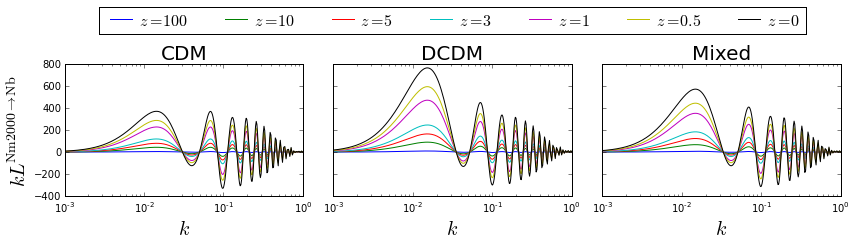

In [5]:
kvec = np.logspace(-5,1,300)
yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
f, axes = plt.subplots(1,3,sharex=True,sharey='row',figsize=(12,3))
for j, M in enumerate(models):

    for idx, z in enumerate(z_pk):
        tr = cosmo[M].get_transfer(z)
        k = tr['k (h/Mpc)']*cosmo[M].h()
        L = tr['L']
        massfunction = tr['L_prime']
        axes[j].semilogx(k,k*L)
#        axes[1,j].semilogx(k,massfunction)
#    axes[0,j].set_ylim(yls[M])
#    axes[1,j].set_ylim([0,4])

axes[0].set_ylabel(r'$kL^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
#axes[1,0].set_ylabel(r'$M(k,z=0)$',fontsize=16)
for j in range(3):
    axes[j].set_title(models[j],fontsize=20)
    axes[j].set_xlabel(r'$k$',fontsize=20)
    axes[j].set_xlim([1e-3,1])    
lgd = axes[1].legend(['$z = '+"{:g}".format(zz)+r'$' for zz in z_pk],
                 fontsize=16,loc='upper center',ncol=len(z_pk),
                bbox_to_anchor=(0.5, 1.5), handletextpad=0.1)
f.tight_layout()
f.savefig('L_and_M_decaying.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

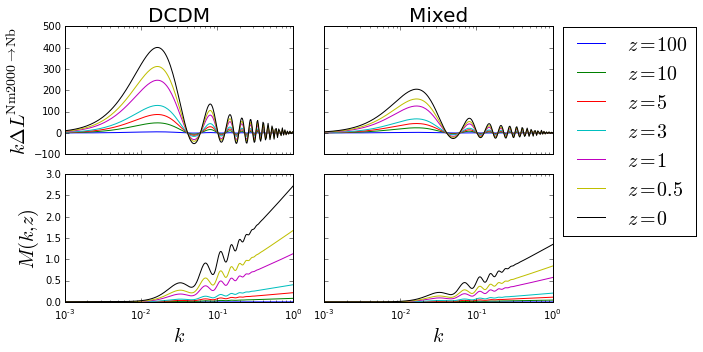

In [6]:
kvec = np.logspace(-5,1,300)
ref = 'CDM'
othermodels = [M for M in models if M!=ref]
yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
f, axes = plt.subplots(2,2,sharex=True,sharey='row',figsize=(8,5))
for j, M in enumerate(othermodels):

    for idx, z in enumerate(z_pk):
        tr = cosmo[M].get_transfer(z)
        trref = cosmo[ref].get_transfer(z)
        k = tr['k (h/Mpc)']*cosmo[M].h()
        Lref_interp = interpolate.interp1d(trref['k (h/Mpc)']*cosmo[ref].h(),trref['L'],bounds_error=False,fill_value=np.NaN)
        L = tr['L']
        Lref = Lref_interp(k)
        mask = ~np.isnan(Lref)
        massfunction = tr['L_prime']
        axes[0,j].semilogx(k[mask],k[mask]*(L[mask]-Lref[mask]))
        axes[1,j].semilogx(k,massfunction)
#    axes[0,j].set_ylim(yls[M])
#    axes[1,j].set_ylim([0,4])

axes[0,0].set_ylabel(r'$k\Delta L^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
axes[1,0].set_ylabel(r'$M(k,z)$',fontsize=20)
for j in range(2):
    axes[0,j].set_title(othermodels[j],fontsize=20)
    axes[-1,j].set_xlabel(r'$k$',fontsize=20)
    axes[-1,j].set_xlim([1e-3,1])    
lgd = axes[0,1].legend(['$z = '+"{:g}".format(zz)+r'$' for zz in z_pk],
                 fontsize=20,loc='upper right',ncol=1,
                bbox_to_anchor=(1.67, 1.075))
f.tight_layout()
f.savefig('L_and_M_decaying2.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')


In [7]:
# Rerun with some contributions switched off:
ratios_cdm = {'CDM':1.,'DCDM':0.,'Mixed':0.5}
Gamma_dcdm = 6.
types = ['_dr_gamma','_only_dr']

for M in models:
    for T in types:
        if T=='_dr_gamma':
            switch_gamma = 1
        else:
            switch_gamma = 0
        cosmo[M+T] = Class()
        cosmo[M+T].set({'output':'mPk dTk lTk', 
           'z_pk':str(z_pk).strip('[]'),
           'k_output_values':str(k_out).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'switch_radiation_source':0,
                  'switch_dr_source':1,
           'switch_gamma':switch_gamma,
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':2,
           'l_max_g':100,
           'l_max_ur':100,
           'l_max_pol_g':100, 
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':60,
           'k_per_decade_for_bao':120,
           'gauge' : 'Newtonian',
           'P_k_max_1/Mpc' : 1.1,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-3,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.24*ratios_cdm[M]+1e-6,
           'Omega_dcdmdr':0.24*(1-ratios_cdm[M]),
           'Gamma_dcdm':Gamma_dcdm,
                  'background_verbose':3})

        cosmo[M+T].compute()

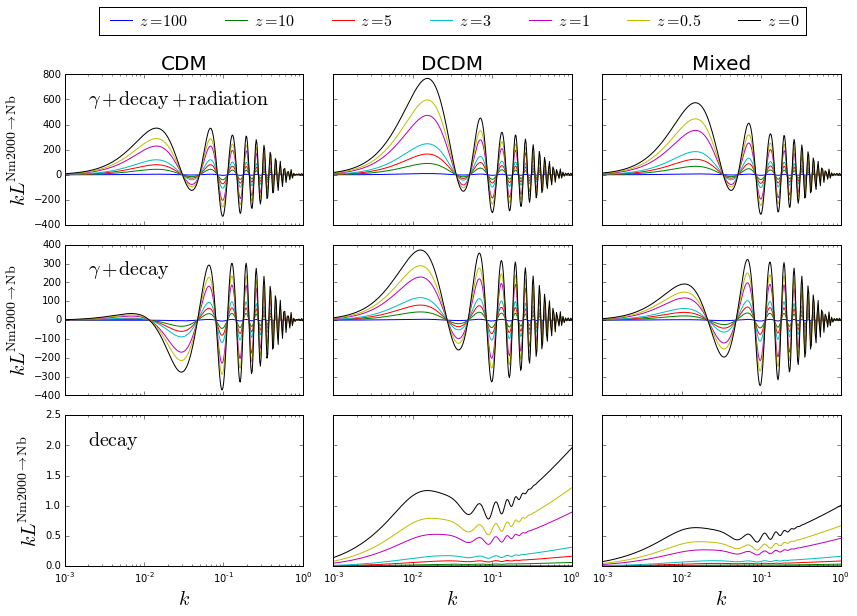

In [8]:
alltypes = ['']+types
kvec = np.logspace(-5,1,300)
yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
f, axes = plt.subplots(len(alltypes),3,sharex=True,sharey='row',figsize=(12,8))
for j, M in enumerate(models):
    for n, T in enumerate(alltypes):
        MT = M+T
        for idx, z in enumerate(z_pk):
            tr = cosmo[MT].get_transfer(z)
            k = tr['k (h/Mpc)']*cosmo[MT].h()
            L = tr['L']
            axes[n,j].semilogx(k,k*L)
#        
for n in range(len(alltypes)):
    if alltypes[n]=='_dr_gamma':
        thestring = r'$\gamma + \mathrm{decay}$'
    elif alltypes[n]=='_only_dr':
        thestring = r'$\mathrm{decay}$'
    else:
        thestring = r'$\gamma + \mathrm{decay}+\mathrm{radiation}$'
    axes[n,0].set_ylabel(r'$kL^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
    axes[n,0].text(0.1,0.8,thestring,transform=axes[n,0].transAxes,fontsize=20)
axes[0,0].set_ylabel(r'$kL^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
#axes[1,0].set_ylabel(r'$M(k,z=0)$',fontsize=16)
for j in range(3):
    axes[0,j].set_title(models[j],fontsize=20)
    axes[-1,j].set_xlabel(r'$k$',fontsize=20)
    axes[-1,j].set_xlim([1e-3,1])    
lgd = axes[0,1].legend(['$z = '+"{:g}".format(zz)+r'$' for zz in z_pk],
                 fontsize=16,loc='upper center',ncol=len(z_pk),
                bbox_to_anchor=(0.5, 1.5), handletextpad=0.1)
f.tight_layout()
f.savefig('L_and_M_decaying3.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [9]:
#Rerun for different z_init:
models = ['CDM','DCDM','Mixed']
ratios_cdm = {'CDM':1.,'DCDM':0.,'Mixed':0.5}
Gamma_dcdm = 6.

#z_pk = [200.0,100.0,75.0,50.0,10.0,5.0,0.0]
z_pk = [100.0,10.0,5.0,3.0,1.0,0.5,0.0]
k_out = [0.00001,0.0001, 0.001, 0.01,.1]
z_init_vec = [2000.,1000.,500.,100.0,10.0,5.0]
cosmo2 = {}
allmodels = [M+'-'+"{:d}".format(nn) for M in models for nn in range(len(z_init_vec))]
for M in allmodels:
    index_z = int(M.split('-')[-1])
    z_init = z_init_vec[index_z]
    print M, z_init
    cosmo2[M] = Class()
    cosmo2[M].set({'output':'mPk dTk lTk', 
           'z_pk':str(z_pk).strip('[]'),
           'k_output_values':str(k_out).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'switch_radiation_source':1,
                  'switch_dr_source':1,
           'switch_gamma':1,
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':2,
           'l_max_g':100,
           'l_max_ur':100,
           'l_max_pol_g':100, 
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':60,
           'k_per_decade_for_bao':120,
           'gauge' : 'Newtonian',
           'P_k_max_1/Mpc' : 1.1,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-3,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.24*ratios_cdm[M.split('-')[0]]+1e-6,
           'Omega_dcdmdr':0.24*(1-ratios_cdm[M.split('-')[0]]),
           'Gamma_dcdm':Gamma_dcdm,
                  'background_verbose':3
#           'N_ur':0.0,
#           'YHe':0.25,
#           'Omega_b':0.05,
#           'Omega_cdm':0.95
            })
#    for key, val in cosmo2[M].pars.iteritems():
#        print key,' = ',val
    cosmo2[M].compute()

CDM-0 2000.0
CDM-1 1000.0
CDM-2 500.0
CDM-3 100.0
CDM-4 10.0
CDM-5 5.0
DCDM-0 2000.0
DCDM-1 1000.0
DCDM-2 500.0
DCDM-3 100.0
DCDM-4 10.0
DCDM-5 5.0
Mixed-0 2000.0
Mixed-1 1000.0
Mixed-2 500.0
Mixed-3 100.0
Mixed-4 10.0
Mixed-5 5.0


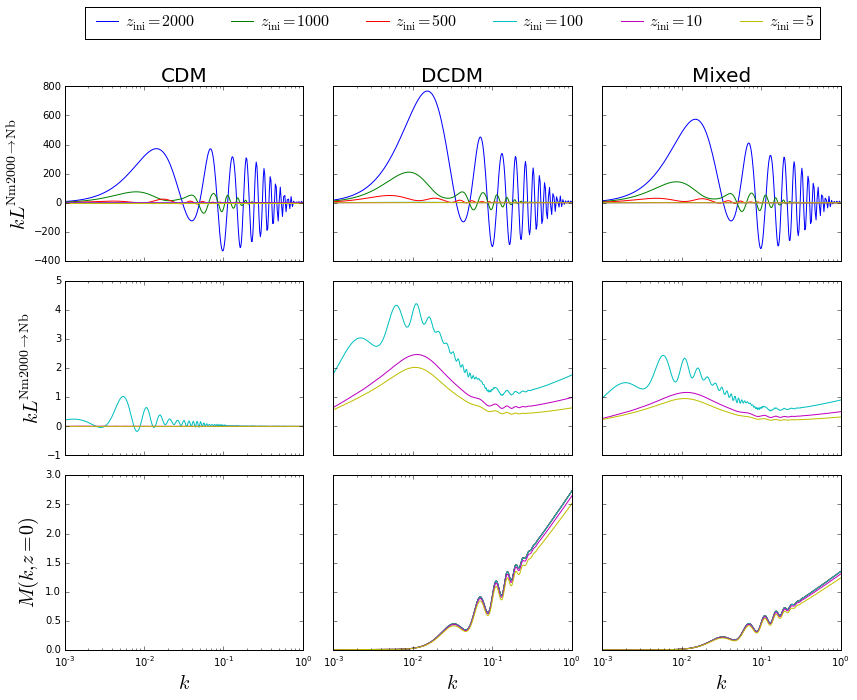

In [25]:
kvec = np.logspace(-5,1,300)
yls = {'CDM':[-1,3],'DCDM':[-4000,1e4],'Mixed':[-30,200]}
f, axes = plt.subplots(3,3,sharex=True,sharey='row',figsize=(12,9))
for j,M in enumerate(models):
    for idx, z in enumerate(z_init_vec):
        mod = M+'-'+str(idx)
        tr = cosmo2[mod].get_transfer(0.)
        k = tr['k (h/Mpc)']*cosmo2[mod].h()
        L = tr['L']
        massfunction = tr['L_prime']
        p = axes[0,j].semilogx(k,k*L)
        if z<400:
            colour = p[0].get_color()
            axes[-2,j].semilogx(k,k*L,color=colour)
        axes[-1,j].semilogx(k,massfunction)
#    axes[0,j].set_ylim(yls[M])
#    axes[1,j].set_ylim([0,4])

for j in range(2):
    axes[j,0].set_ylabel(r'$kL^{\mathrm{Nm2000}\rightarrow \mathrm{Nb}}$',fontsize=20)
axes[-1,0].set_ylabel(r'$M(k,z=0)$',fontsize=20)
    #axes[1,0].set_ylabel(r'$M(k,z=0)$',fontsize=16)
for j in range(3):
    axes[0,j].set_title(models[j],fontsize=20)
    axes[-1,j].set_xlabel(r'$k$',fontsize=20)
    axes[-1,j].set_xlim([1e-3,1])    
lgd = axes[0,1].legend(['$z_\mathrm{ini} = '+"{:g}".format(zz)+r'$' for zz in z_init_vec],
                 fontsize=16,loc='upper center',ncol=len(z_pk),
                bbox_to_anchor=(0.5, 1.5), handletextpad=0.1)
f.tight_layout()
f.savefig('L_and_M_decaying4.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')